# Projet MonteCarlo 
## Application des méthodes MonteCarlo sur le jeu de Puissance 4

**Auteurs:** Jihed BHAR - Yassine BEN ABDALLAH - Nadia BEN YOUSSEF


----

### Importation des librairies

In [1]:
import numpy as np
import math
import random
from copy import deepcopy
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

### Implémentation de la classe Connect4Game

In [2]:
class Connect4Game:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.current_player = 1
        self.game_over = False
        self.winner = None

    def get_valid_moves(self):
        return [col for col in range(self.columns) if self.board[0][col] == 0]

    def make_move(self, column):
        if column not in self.get_valid_moves():
            return False
        for row in range(self.rows-1, -1, -1):
            if self.board[row][column] == 0:
                self.board[row][column] = self.current_player
                break
        if self.check_win(self.current_player):
            self.game_over = True
            self.winner = self.current_player
        elif not self.get_valid_moves():
            self.game_over = True
        self.current_player = 3 - self.current_player
        return True

    def check_win(self, player):
        for row in range(self.rows):
            for col in range(self.columns - 3):
                if all(self.board[row][col+i] == player for i in range(4)):
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns):
                if all(self.board[row+i][col] == player for i in range(4)):
                    return True
        for row in range(self.rows - 3):
            for col in range(self.columns - 3):
                if all(self.board[row+i][col+i] == player for i in range(4)):
                    return True
                if all(self.board[row+3-i][col+i] == player for i in range(4)):
                    return True
        return False

    def print_board(self):
        print('-' * (2 * self.columns + 1))
        for row in range(self.rows):
            print('|', end='')
            for col in range(self.columns):
                print(' ' if self.board[row][col] == 0 else 'R' if self.board[row][col] == 1 else 'Y', end='|')
            print()
        print('-' * (2 * self.columns + 1))
        print(' ', end='')
        for col in range(self.columns):
            print(f'{col}', end=' ')
        print()

### Implémentation de la classe Node

In [3]:
class Node:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = deepcopy(game_state)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.sum_of_squares = 0
        self.untried_moves = game_state.get_valid_moves()

    def select_child(self):
        c = 1.41
        best_score = -float('inf')
        best_child = None
        for child in self.children:
            exploitation = child.wins / child.visits if child.visits > 0 else 0
            exploration = math.sqrt(2 * math.log(self.visits) / child.visits) if child.visits > 0 else float('inf')
            score = exploitation + c * exploration
            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def add_child(self, move, game_state):
        child = Node(game_state, self, move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result
        self.sum_of_squares += result * result

### Implémentation de l'algorithme Monte Carlo Tree Search (MCTS) standard

In [4]:
class MCTS:
    def __init__(self,game, iterations=1000):  # Réduit à 1000 pour test
        self.iterations = iterations
        self.game = game

    def get_best_move(self):
        root = Node(self.game)
        for _ in range(self.iterations):
            node = root
            state = deepcopy(self.game)
            while node.untried_moves == [] and node.children != []:
                node = node.select_child()
                state.make_move(node.move)
            if node.untried_moves:
                move = random.choice(node.untried_moves)
                state.make_move(move)
                node = node.add_child(move, state)
            while not state.game_over and state.get_valid_moves():
                state.make_move(random.choice(state.get_valid_moves()))  # Simulation aléatoire
            while node:
                result = 0.5 if state.winner is None else 1.0 if state.winner == self.game.current_player else 0.0
                node.update(result)
                node = node.parent
        best_child = max(root.children, key=lambda c: c.visits, default=None)
        return best_child.move if best_child else random.choice(self.game.get_valid_moves())

### Implémentation de l'algorithme NRPA

In [5]:
class NRPA:
    def __init__(self, game, level=2, iterations=100):
        self.game = game
        self.level = level          # Niveau de récursion
        self.iterations = iterations # Nombre d'itérations par niveau
        self.policy = {}           
        
    def get_key(self, board):
        """Convertit le plateau en une chaîne de caractères unique pour l'utiliser comme clé"""
        return str(board.flatten().tolist())
    
    def adapt_policy(self, trajectory, reward):
        """Adapte la politique en fonction de la trajectoire et de la récompense obtenue"""
        alpha = 0.5  # Taux d'apprentissage
        
        for state, action in trajectory:
            state_key = self.get_key(state)
            if state_key not in self.policy:
                valid_moves = [col for col in range(self.game.columns) if state[0][col] == 0]
                self.policy[state_key] = {move: 0.0 for move in valid_moves}
            
            policy_values = self.policy[state_key]
            exp_values = {a: math.exp(w) for a, w in policy_values.items()}
            total_exp = sum(exp_values.values())
            probs = {a: v / total_exp if total_exp > 0 else 1.0 / len(exp_values) 
                    for a, v in exp_values.items()}
            old_weight = self.policy[state_key].get(action, 0.0)
            self.policy[state_key][action] = old_weight + alpha * reward * (1.0 - probs[action])
            
            for a in self.policy[state_key]:
                if a != action:
                    old_weight = self.policy[state_key][a]
                    self.policy[state_key][a] = old_weight - alpha * reward * probs[a]
    
    def select_action(self, state):
        """Sélectionne une action en fonction de la politique actuelle"""
        state_key = self.get_key(state)
        
        if state_key not in self.policy:
            valid_moves = [col for col in range(self.game.columns) if state[0][col] == 0]
            self.policy[state_key] = {move: 0.0 for move in valid_moves}
        
        policy_values = self.policy[state_key]
        if not policy_values:  # Si aucune action n'est disponible
            return None
        
        exp_values = {a: math.exp(w) for a, w in policy_values.items()}
        total_exp = sum(exp_values.values())
        
        if total_exp == 0:
            return random.choice(list(policy_values.keys()))
        
        probs = {a: v / total_exp for a, v in exp_values.items()}
        
        actions = list(probs.keys())
        probabilities = [probs[a] for a in actions]
        return np.random.choice(actions, p=probabilities)
    
    def playout(self, state, player):
        """Effectue un playout à partir de l'état donné"""
        trajectory = []
        game_copy = copy.deepcopy(self.game)
        game_copy.board = copy.deepcopy(state)
        game_copy.current_player = player
        
        while not game_copy.game_over:
            valid_moves = game_copy.get_valid_moves()
            if not valid_moves:
                break
            
            state_key = self.get_key(game_copy.board)
            if state_key in self.policy and any(move in self.policy[state_key] for move in valid_moves):
                action = self.select_action(game_copy.board)
                if action is None or action not in valid_moves:
                    action = random.choice(valid_moves)
            else:
                action = random.choice(valid_moves)
            trajectory.append((copy.deepcopy(game_copy.board), action))
            game_copy.make_move(action)
        
        if game_copy.winner == player:
            return trajectory, 1.0  # Victoire
        elif game_copy.winner == 3 - player:
            return trajectory, 0.0  # Défaite
        else:
            return trajectory, 0.5  # Match nul
    
    def nested_rollout(self, state, player, level):
        """Effectue un rollout imbriqué de niveau donné"""
        if level == 0:
            trajectory, reward = self.playout(state, player)
            return reward, trajectory
        
        best_score = -1
        best_trajectory = None
        
        for _ in range(self.iterations):
            old_policy = copy.deepcopy(self.policy)
            # Effectuer un rollout et obtenir une trajectoire
            score, trajectory = self.nested_rollout(state, player, level - 1)
            if score > best_score:
                best_score = score
                best_trajectory = trajectory
            if trajectory:
                self.adapt_policy(trajectory, score)
        
        # Restaurer l'ancienne politique
        self.policy = old_policy
        
        return best_score, best_trajectory
    
    def get_best_move(self):
        """Retourne le meilleur mouvement selon NRPA"""
        best_score = -1
        best_move = None
        score, trajectory = self.nested_rollout(self.game.board, self.game.current_player, self.level)
        
        if trajectory and len(trajectory) > 0:
            _, best_move = trajectory[0]
        else:
            valid_moves = self.game.get_valid_moves()
            if valid_moves:
                best_move = random.choice(valid_moves)
        
        return best_move

In [6]:
def test_algorithms(num_games=100, mcts_iterations=1000, nrpa_level=2, nrpa_iterations=100):
    """
    Teste les performances de MCTS vs NRPA sur plusieurs parties de Puissance 4.
    
    Args:
        num_games: Nombre de parties à jouer
        mcts_iterations: Nombre d'itérations pour MCTS
        nrpa_level: Niveau de récursion pour NRPA
        nrpa_iterations: Nombre d'itérations par niveau pour NRPA
        
    Returns:
        Statistiques des résultats
    """
    results = {'MCTS_win': 0, 'NRPA_win': 0, 'Draw': 0}
    moves_count = []
    game_times = {'MCTS': [], 'NRPA': []}
    
    for game_id in tqdm(range(num_games), desc="Parties jouées"):
        game = Connect4Game()
        mcts_first = game_id % 2 == 0
        mcts_agent = MCTS(deepcopy(game) ,mcts_iterations)
        nrpa_agent = NRPA(deepcopy(game), nrpa_level, nrpa_iterations)
        move_count = 0
        
        while not game.game_over:
            current_player_num = game.current_player
            if (current_player_num == 1 and mcts_first) or (current_player_num == 2 and not mcts_first):
                agent = mcts_agent
                player_name = "MCTS"
            else:
                agent = nrpa_agent
                player_name = "NRPA"
            agent.game = deepcopy(game)
            start_time = time.time()
            move = agent.get_best_move()
            end_time = time.time()
            game_times[player_name].append(end_time - start_time)
            game.make_move(move)
            move_count += 1
        
        moves_count.append(move_count)
        game.print_board()
        if game.winner is None:
            results['Draw'] += 1
        elif (game.winner == 1 and mcts_first) or (game.winner == 2 and not mcts_first):
            results['MCTS_win'] += 1
        else:
            results['NRPA_win'] += 1
    
    avg_moves = sum(moves_count) / len(moves_count)
    avg_time_mcts = sum(game_times['MCTS']) / len(game_times['MCTS']) if game_times['MCTS'] else 0
    avg_time_nrpa = sum(game_times['NRPA']) / len(game_times['NRPA']) if game_times['NRPA'] else 0
    
    print(f"\nRésultats après {num_games} parties :")
    print(f"MCTS a gagné {results['MCTS_win']} parties ({results['MCTS_win']/num_games*100:.1f}%)")
    print(f"NRPA a gagné {results['NRPA_win']} parties ({results['NRPA_win']/num_games*100:.1f}%)")
    print(f"Matchs nuls : {results['Draw']} parties ({results['Draw']/num_games*100:.1f}%)")
    print(f"\nNombre moyen de coups par partie : {avg_moves:.1f}")
    print(f"Temps moyen par coup - MCTS : {avg_time_mcts:.3f} secondes")
    print(f"Temps moyen par coup - NRPA : {avg_time_nrpa:.3f} secondes")
    plot_results(results, avg_time_mcts, avg_time_nrpa, avg_moves)
    
    return results, moves_count, game_times

def plot_results(results, avg_time_mcts, avg_time_nrpa, avg_moves):
    """
    Affiche des graphiques avec les résultats des tests.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    labels = ['MCTS', 'NRPA', 'Match nul']
    sizes = [results['MCTS_win'], results['NRPA_win'], results['Draw']]
    colors = ['lightblue', 'lightgreen', 'lightgray']
    
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    ax1.set_title('Résultats des parties')
    
    algorithms = ['MCTS', 'NRPA']
    times = [avg_time_mcts, avg_time_nrpa]
    
    bars = ax2.bar(algorithms, times, color=['lightblue', 'lightgreen'])
    ax2.set_title('Temps moyen par coup (secondes)')
    ax2.set_ylabel('Secondes')
    
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def compare_configs(all_results):
    """
    Compare les résultats de différentes configurations.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    configs = []
    mcts_wins = []
    nrpa_wins = []
    draws = []
    mcts_times = []
    nrpa_times = []
    
    for result in all_results:
        config = result['config']
        configs.append(f"M{config['mcts_iterations']}-N{config['nrpa_level']},{config['nrpa_iterations']}")
        
        total_games = config['games']
        mcts_wins.append(result['results']['MCTS_win'] / total_games * 100)
        nrpa_wins.append(result['results']['NRPA_win'] / total_games * 100)
        draws.append(result['results']['Draw'] / total_games * 100)
        
        mcts_times.append(sum(result['times']['MCTS']) / len(result['times']['MCTS']) if result['times']['MCTS'] else 0)
        nrpa_times.append(sum(result['times']['NRPA']) / len(result['times']['NRPA']) if result['times']['NRPA'] else 0)
    
    x = np.arange(len(configs))
    width = 0.25
    
    ax1.bar(x - width, mcts_wins, width, label='MCTS', color='lightblue')
    ax1.bar(x, nrpa_wins, width, label='NRPA', color='lightgreen')
    ax1.bar(x + width, draws, width, label='Match nul', color='lightgray')
    
    ax1.set_ylabel('Pourcentage (%)')
    ax1.set_title('Taux de victoire par configuration')
    ax1.set_xticks(x)
    ax1.set_xticklabels(configs, rotation=45)
    ax1.legend()
    
    ax2.plot(configs, mcts_times, 'o-', label='MCTS', color='blue')
    ax2.plot(configs, nrpa_times, 'o-', label='NRPA', color='green')
    
    ax2.set_ylabel('Temps (secondes)')
    ax2.set_title('Temps moyen par coup')
    ax2.set_xticklabels(configs, rotation=45)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


#### Configuration 1


Test avec MCTS:500 vs NRPA niveau:1, iter:10


Parties jouées:  10%|█         | 2/20 [00:03<00:27,  1.54s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | |Y|Y| | | |
| |R|R|R|R| |Y|
| |Y|Y|R|R|R|Y|
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| |R| |
|R|R| |Y| |R| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  15%|█▌        | 3/20 [00:04<00:27,  1.63s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| |Y|R|R|R|R| |
| |R|Y|R|Y|Y|Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  20%|██        | 4/20 [00:06<00:27,  1.73s/it]

---------------
| | | | | | | |
| |R| | | | | |
| |Y| | | | | |
| |Y|Y| | | | |
| |R|R|Y| | | |
| |R|Y|R|Y|R| |
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | |R|
| | | |R|R|R|R|
| | | |R|Y|Y|Y|
|Y|Y|R|R|Y|R|Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  30%|███       | 6/20 [00:11<00:28,  2.04s/it]

---------------
| | | | | | | |
| | | | |Y| | |
| | |R| |Y| | |
| | |R|Y|Y| | |
| | |Y|R|Y| | |
| |R|R|Y|R|R| |
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | |Y|Y| | | |
| | |Y|R|R|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  40%|████      | 8/20 [00:13<00:18,  1.56s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |R| | | |
|R|Y|Y|Y|Y|R|R|
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
|Y| |Y|R|R|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  55%|█████▌    | 11/20 [00:20<00:19,  2.16s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| |R|Y|Y| | | |
| |Y|Y|Y|Y| | |
| |R|R|Y|R|R|R|
---------------
 0 1 2 3 4 5 6 
---------------
| | | |Y| | | |
| | |Y|R| |R| |
| | |R|R| |R| |
|Y| |Y|R| |R| |
|Y|Y|R|Y| |R| |
|R|Y|Y|R| |Y| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  60%|██████    | 12/20 [00:21<00:15,  1.89s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | |R|Y| | | |
| | |R|Y|R|R| |
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |R| | | |
| | | |R| | | |
|Y|Y| |R| | |Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  70%|███████   | 14/20 [00:24<00:09,  1.62s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | |R|Y| | | |
|R| |Y|Y| | | |
|R| |R|Y|R| | |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  80%|████████  | 16/20 [00:27<00:06,  1.69s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| |R|R|R|R| |Y|
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | | | |Y| | |
| | |Y|Y|R| | |
| | |R|R|R| | |
| | |Y|Y|Y|Y| |
| | |R|Y|R|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  85%|████████▌ | 17/20 [00:29<00:05,  1.84s/it]

---------------
| |Y| | | | | |
| |Y|R| | | | |
| |R|R| | | | |
| |Y|R|Y| | | |
| |R|R|R| | |R|
| |Y|Y|R|Y| |Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  95%|█████████▌| 19/20 [00:33<00:01,  1.76s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
|R| |Y|Y| |Y|R|
|R| |R|Y| |R|R|
---------------
 0 1 2 3 4 5 6 
---------------
| | | | | | | |
| | |R| | | | |
| | |R| | | | |
| | |R| | | | |
| | |R| | | | |
|Y|Y|Y|R| | |Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]

---------------
| | | | | | | |
| | | | | | | |
| | |R| |Y| | |
| | |Y|R|Y| | |
|R| |R|Y|Y| | |
|R|Y|R|R|Y| | |
---------------
 0 1 2 3 4 5 6 

Résultats après 20 parties :
MCTS a gagné 20 parties (100.0%)
NRPA a gagné 0 parties (0.0%)
Matchs nuls : 0 parties (0.0%)

Nombre moyen de coups par partie : 11.6
Temps moyen par coup - MCTS : 0.269 secondes
Temps moyen par coup - NRPA : 0.024 secondes


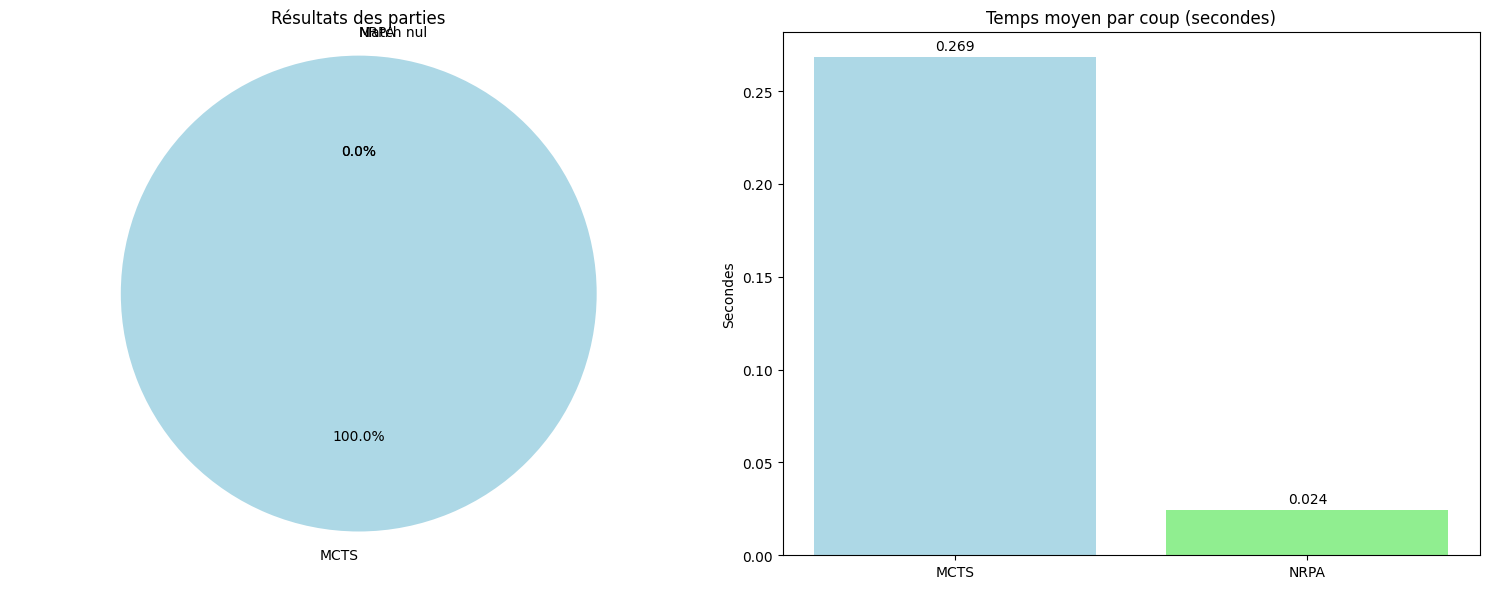

In [7]:
if __name__ == "__main__":
    config = {"mcts_iterations": 500, "nrpa_level": 1, "nrpa_iterations": 10, "games": 20}
    
    print(f"\nTest avec MCTS:{config['mcts_iterations']} vs NRPA niveau:{config['nrpa_level']}, iter:{config['nrpa_iterations']}")
    results1, moves1, times1 = test_algorithms(
        num_games=config['games'],
        mcts_iterations=config['mcts_iterations'],
        nrpa_level=config['nrpa_level'],
        nrpa_iterations=config['nrpa_iterations']
    )
    
    result1 = {
        'config': config,
        'results': results1,
        'moves': moves1,
        'times': times1
    }

#### Configuration 2


Test avec MCTS:1000 vs NRPA niveau:2, iter:20


Parties jouées:   5%|▌         | 1/20 [01:09<21:53, 69.12s/it]

---------------
| | | | | | | |
| |R| | | | | |
| |R| | | | | |
| |R| | | | | |
| |R| | |Y| | |
| |Y|R| |Y|Y| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  10%|█         | 2/20 [05:11<51:16, 170.94s/it]

---------------
| |Y| | | | | |
| |Y| |R| | | |
| |Y| |Y| |R| |
| |Y| |R| |Y| |
| |R| |Y| |R| |
| |R| |Y|R|R| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  15%|█▌        | 3/20 [05:49<31:13, 110.22s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | |Y| | | | |
|R|R|R|R|Y| |Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  20%|██        | 4/20 [06:55<24:45, 92.82s/it] 

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| |R| |Y| | | |
| |R| |Y|R| |R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  25%|██▌       | 5/20 [09:38<29:33, 118.26s/it]

---------------
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |R| |R| |
| | |Y|R| |Y|Y|
|Y|R|R|R|R|Y|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  30%|███       | 6/20 [25:02<1:31:28, 392.00s/it]

---------------
| | |R|Y| | | |
| | |Y|Y| | | |
| | |R|R| | | |
| | |Y|Y|R| | |
| | |R|Y|Y|R|Y|
|R|R|R|Y|R|Y|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  35%|███▌      | 7/20 [26:36<1:03:50, 294.68s/it]

---------------
| | | | | | | |
| | | | | | | |
| | |Y| | | | |
| | |Y|Y| | | |
| |R|R|R|R| | |
| |R|Y|R|Y| | |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  40%|████      | 8/20 [28:18<46:38, 233.21s/it]  

---------------
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| | |R|
| | |R|R|Y|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  45%|████▌     | 9/20 [28:58<31:42, 172.98s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | |Y| |
| |Y|Y|R|R|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  50%|█████     | 10/20 [42:35<1:01:59, 371.90s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| | | |
|R| |R|Y|R| |R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  55%|█████▌    | 11/20 [43:14<40:28, 269.83s/it]  

---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |R| | | |
| |Y| |R| | | |
| |Y| |R| | |Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  60%|██████    | 12/20 [44:49<28:52, 216.58s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | |Y| | |
| | | |Y|R| | |
| | |Y|R|R| | |
| |Y|R|R|Y| | |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  65%|██████▌   | 13/20 [46:59<22:14, 190.58s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |Y|Y| | |
| | | |Y|R| |Y|
|R|R|R|R|Y|Y|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  70%|███████   | 14/20 [48:07<15:19, 153.33s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
|R| | | | | | |
|R|Y|Y|Y|Y|R|R|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  75%|███████▌  | 15/20 [48:45<09:53, 118.65s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |R| | | |
| | | |R| | | |
| | | |R| | | |
| | |Y|R| |Y|Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées:  80%|████████  | 16/20 [55:15<13:21, 200.38s/it]

---------------
| | | | | | | |
| | | |R| | | |
| | | |R| |Y| |
| |R| |Y|Y|R| |
|Y|Y| |Y|R|Y| |
|R|R|Y|Y|R|R| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  85%|████████▌ | 17/20 [59:47<11:05, 221.94s/it]

---------------
| | | | | | | |
| | | | |R| | |
| | | |Y|R| | |
| |Y|R|R|R|R| |
| |R|Y|R|Y|R| |
|Y|Y|Y|R|Y|Y| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  90%|█████████ | 18/20 [1:00:56<05:51, 175.90s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | | |Y| |R| |
| |R| |Y|R|R| |
---------------
 0 1 2 3 4 5 6 


Parties jouées:  95%|█████████▌| 19/20 [1:01:33<02:14, 134.27s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | |Y| | |
| |Y|R|R|R|R|Y|
---------------
 0 1 2 3 4 5 6 


Parties jouées: 100%|██████████| 20/20 [1:02:43<00:00, 188.15s/it]

---------------
| | | | | | | |
| | | | | | | |
| | | |Y| | | |
| | | |Y| | | |
| | |R|Y| |R| |
| | |R|Y| |R| |
---------------
 0 1 2 3 4 5 6 

Résultats après 20 parties :
MCTS a gagné 19 parties (95.0%)
NRPA a gagné 1 parties (5.0%)
Matchs nuls : 0 parties (0.0%)

Nombre moyen de coups par partie : 10.8
Temps moyen par coup - MCTS : 0.550 secondes
Temps moyen par coup - NRPA : 35.585 secondes


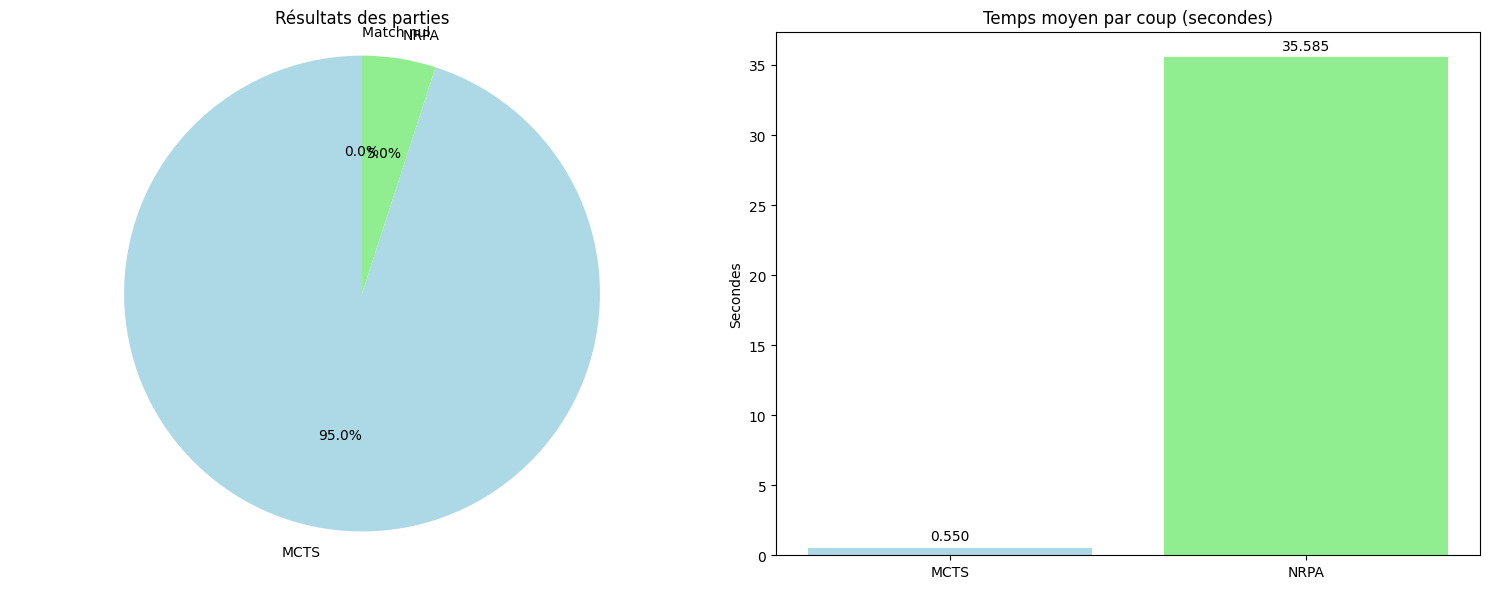

In [8]:
if __name__ == "__main__":
    config = {"mcts_iterations": 1000, "nrpa_level": 2, "nrpa_iterations": 20, "games": 20}
    
    print(f"\nTest avec MCTS:{config['mcts_iterations']} vs NRPA niveau:{config['nrpa_level']}, iter:{config['nrpa_iterations']}")
    results2, moves2, times2 = test_algorithms(
        num_games=config['games'],
        mcts_iterations=config['mcts_iterations'],
        nrpa_level=config['nrpa_level'],
        nrpa_iterations=config['nrpa_iterations']
    )
    
    result2 = {
        'config': config,
        'results': results2,
        'moves': moves2,
        'times': times2
    }


### Comparaison

/var/folders/gr/37ts_6nn34qbcw22dqxnvqx80000gn/T/ipykernel_1830/3615066601.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(configs, rotation=45)


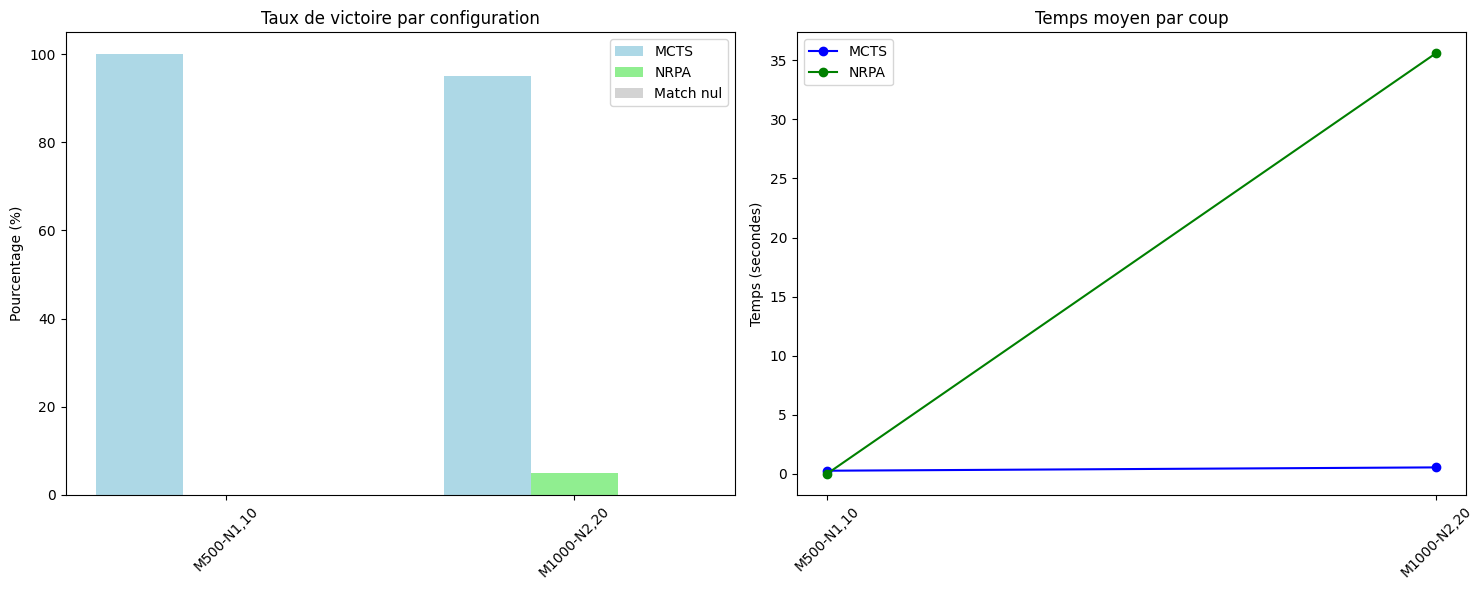

In [ ]:
if __name__ == "__main__":
    all_results = [result1, result2]
    compare_configs(all_results)